In [1]:
import pandas
import numpy as np
from utils import *
import mne
import matplotlib.pyplot as plt
from os import walk
from sklearn.decomposition import FastICA
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import normalize
from tqdm.notebook import tqdm
import pickle

from multiprocessing import Pool
plt.style.use('seaborn-whitegrid')

# Groud truth - Median

In [2]:
df = pandas.read_csv('./HEXACO.csv')
# Honesty-Humility	Emotionality	eXtraversion	Agreeableness	Conscientiousness	Openness to Experience
gt = df[['id','Honesty-Humility','Emotionality','eXtraversion','Agreeableness','Conscientiousness','Openness to Experience']].rename(columns={'Honesty-Humility':'h',
                                  'Emotionality':'e',
                                  'eXtraversion':'x',
                                 'Agreeableness':'a',
                             'Conscientiousness':'c',
                        'Openness to Experience':'o'}).set_index('id')

gt['lh'] = (gt[['h']] > np.median(gt['h'])) * 1
gt['le'] = (gt[['e']] > np.median(gt['e'])) * 1
gt['lx'] = (gt[['x']] > np.median(gt['x'])) * 1
gt['la'] = (gt[['a']] > np.median(gt['a'])) * 1
gt['lc'] = (gt[['c']] > np.median(gt['c'])) * 1
gt['lo'] = (gt[['o']] > np.median(gt['o'])) * 1
gt

,h,e,x,a,c,o,lh,le,lx,la,lc,lo
id,,,,,,,,,,,,
2,3.63,3.19,2.94,2.38,3.38,2.38,1,0,0,0,0,0
3,3.38,3.44,3.50,3.50,4.50,3.81,0,0,1,1,1,1
4,3.19,3.75,3.69,3.19,2.63,2.63,0,1,1,0,0,0
5,3.25,3.63,2.13,3.56,3.63,2.31,0,1,0,1,1,0
6,3.25,2.75,3.50,2.50,3.75,5.00,0,0,1,0,1,1
7,4.06,3.06,3.38,2.88,2.50,4.19,1,0,1,0,0,1
8,3.94,2.94,3.19,3.75,3.38,3.81,1,0,1,1,0,1
9,4.44,4.00,3.38,3.75,3.69,3.31,1,1,1,1,1,0
10,3.63,3.25,3.50,3.31,3.88,2.69,1,0,1,1,1,0


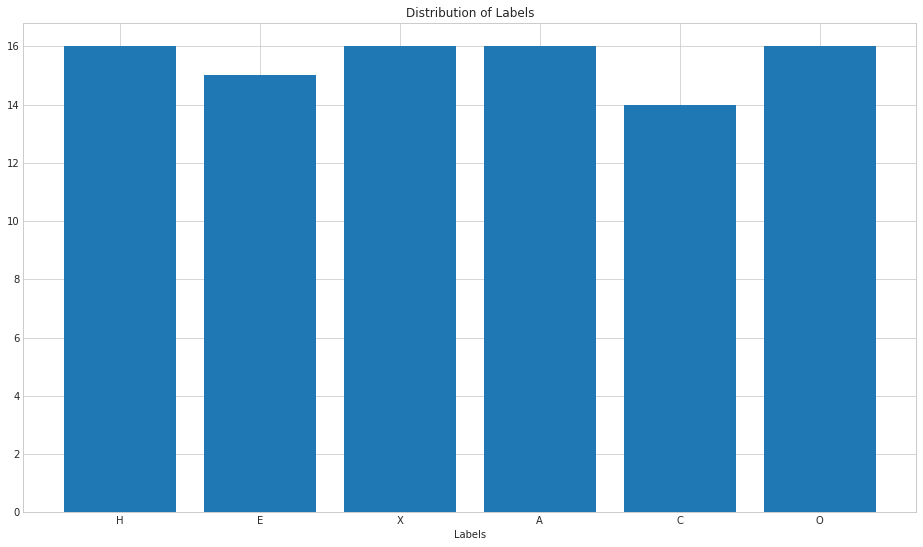

In [3]:
fig, ax = plt.subplots(figsize=(16,9))
ax.bar(['H','E','X','A','C','O'],[ sum(gt['lh']), sum(gt['le']), sum(gt['lx']), sum(gt['la']), sum(gt['lc']), sum(gt['lo'])  ])
ax.set_title("Distribution of Labels")
ax.set_xlabel("Labels")
# ax.set_ylabel("Distribution of Labels")
plt.show()

# EEG data

In [4]:
def load_data():
    path, folders, filenames = next(walk('./data'))

    filenames.remove('11-audio.csv')
    filenames.remove('11-image.csv')

    filenames.remove('36-audio.csv')
    filenames.remove('36-image.csv')

    path = './data'
    columns = {'Unnamed: 1':'Fp1',
            'Unnamed: 2':'Fp2',
            'Unnamed: 3':'F3',
            'Unnamed: 4':'F4',
            'Unnamed: 5':'F7',
            'Unnamed: 6':'F8',
            'Unnamed: 7':'P7',
            'Unnamed: 8':'P8'}

    EEG_audio, EEG_image = dict(), dict()
    from itertools import product
    categories = [1,2,3,4,5]
    blocks = [1,2]
    with tqdm(filenames) as t:
        for filename in t:
            t.set_description(f"{filename}")
            participant_id, stimuli = filename.split('-')
            stimuli = stimuli.rstrip('.csv')
            data = pandas.read_csv(f'{path}/{filename}', dtype={'Marker': str}).rename(columns=columns).drop(columns='timestamps')
            # Aviod warning on stim has negative value
            marker = np.array(data['Marker'])
            marker[marker == '-1'] = '1'
            data['Marker'] = marker

            if(stimuli == 'audio'):
                EEG_audio[int(participant_id)] = data
            elif(stimuli == 'image'):
                EEG_image[int(participant_id)] = data
            else:
                raise ValueError(f"Stimuli:{stimuli} is unexpected.")
    return EEG_audio, EEG_image


In [5]:
# clear_cache()
try:
    # Load from cache
    EEG_audio = load('EEG_audio')
    EEG_image = load('EEG_image')
    print('Load data from cache')
    if( set(EEG_audio.keys()) != set(EEG_image.keys()) ):
        extra = None
        if(len(EEG_audio.keys()) > len(EEG_image.keys())):
            extra = set(EEG_audio.keys()).difference( set(EEG_image.keys()) )
        else:
            extra = set(EEG_image.keys()).difference( set(EEG_audio.keys()) )
        raise ValueError(f"In equal keys. audio has {len(EEG_audio.keys())} and image has {len(EEG_image.keys())}. The extra key is {extra}")

except FileNotFoundError as e:
    EEG_audio, EEG_image = load_data()
    # Save to cache
    save(EEG_audio, 'EEG_audio')
    save(EEG_image, 'EEG_image')

Load data from cache


# Pre process with PSD + log + mne ICA

In [6]:
# raw = dataframe_to_raw(EEG_image[33], sfreq=250)
            
# # Preprocess
# raw.notch_filter([50,100],filter_length='auto', phase='zero', verbose=False) # Line power
# raw.filter(1., None, verbose=False) # Slow drift
# events = mne.find_events(raw, stim_channel='Marker', initial_event=True, verbose=False, uint_cast=False)
# events = np.delete(events,np.argwhere(events[:,2] == 1), axis=0) # break
# # Check data
# if(events.shape[0] != 50):
#     raise ValueError(f"Event missing: {events[:,2]}. len(events.shape[0])={events.shape[0]}")
# epochs = mne.Epochs(raw, events, tmin=0.3, tmax=5.8, baseline=(0.3,0.3), verbose=False)
# if(epochs.get_data().shape[0] != 50):
#     raise ValueError(f"There might be a bad data. epochs.get_data().shape = {epochs.get_data().shape}")

# # Extract features
# ica = mne.preprocessing.ICA(n_components=8, max_iter='auto')
# ica.fit(epochs, verbose=False)
# for evoked in epochs.iter_evoked():
#     reduc = ica.apply(evoked, verbose=False)
#     power,freq = mne.time_frequency.psd_array_welch(reduc.data[:6],sfreq=250,n_fft=128, verbose=False)
#     break

In [7]:
# power,freq = mne.time_frequency.psd_array_welch(reduc.data[:1],sfreq=250,n_fft=128, verbose=False)

In [8]:
# reduc.data.shape

In [9]:
# power.mean(axis=0).shape

In [12]:
def build_data(p_num, EEG,ids):
    X = None
    Y = None
    # Delta, Theta, Alpha, Beta, Gamma
    filter_list = [[0,4],[4,8],[8,13],[13,30],[30,125]]
    with tqdm(ids) as t:
        for index, id in enumerate(t):
            t.set_description(f"{id}")
            print(f"p_no={p_num}|index={index}|id={id}")
            raw = dataframe_to_raw(EEG[id], sfreq=250)
            
            # Preprocess
            raw.notch_filter([50,100],filter_length='auto', phase='zero', verbose=False) # Line power
            raw.filter(1., None, verbose=False) # Slow drift
            ica = mne.preprocessing.ICA(n_components=8, max_iter='auto')
            ica.fit(raw, verbose=False)
            raw = ica.apply(raw, verbose=False)

            events = mne.find_events(raw, stim_channel='Marker', initial_event=True, verbose=False, uint_cast=False)
            events = np.delete(events,np.argwhere(events[:,2] == 1), axis=0) # break
            # Check data
            if(events.shape[0] != 50):
                raise ValueError(f"Event missing: {events[:,2]}. len(events.shape[0])={events.shape[0]}")
            epochs = mne.Epochs(raw, events, tmin=0.3, tmax=5.8, baseline=(0.3,0.3), verbose=False)
            if(epochs.get_data().shape[0] != 50):
                raise ValueError(f"There might be a bad data. epochs.get_data().shape = {epochs.get_data().shape}")

            # Extract features

            for evoked in epochs.iter_evoked():
                power,freq = mne.time_frequency.psd_array_welch(evoked.data,sfreq=250,n_fft=128, verbose=False)
                row = power.mean(axis=0)
                row = np.expand_dims(row.reshape(-1), axis=0)
                row = 10 * np.log10(row)
                if(type(X) == type(None)): X = row
                else: X = np.concatenate( [X, row ], axis=0 )

                label = gt.loc[id][['lh','le','lx','la','lc','lo']].to_numpy()
                label = np.expand_dims(label, axis=0)
                if(type(Y) == type(None)): Y = label
                else: Y = np.concatenate( [Y, label ], axis=0 )

    print(f"{p_num} done| {ids}")
    return np.array(X),np.array(Y)

In [13]:
try:
    # [33,2,10,12,16]
    t_out = 300
    pool = Pool()
    ids = np.array(list(EEG_image.keys()))
    p1 = pool.apply_async(build_data, [1,EEG_image,ids[0::6]])
    p2 = pool.apply_async(build_data, [2,EEG_image,ids[1::6]])
    p3 = pool.apply_async(build_data, [3,EEG_image,ids[2::6]])
    p4 = pool.apply_async(build_data, [4,EEG_image,ids[3::6]])
    p5 = pool.apply_async(build_data, [5,EEG_image,ids[4::6]])
    p6 = pool.apply_async(build_data, [6,EEG_image,ids[5::6]])
    ans1 = p1.get(timeout=t_out)
    ans2 = p2.get(timeout=t_out)
    ans3 = p3.get(timeout=t_out)
    ans4 = p4.get(timeout=t_out)
    ans5 = p5.get(timeout=t_out)
    ans6 = p6.get(timeout=t_out)
    X = np.concatenate([ans1[0] , ans2[0], ans3[0], ans4[0] ,ans5[0], ans6[0]])
    Y = np.concatenate([ans1[1] , ans2[1], ans3[1], ans4[1] ,ans5[1], ans6[1]])
    print(X.shape, Y.shape)
finally:
    print("========= close ========")
    pool.close() 
    pool.terminate()

p_no=1|index=0|id=10
p_no=2|index=0|id=12
p_no=3|index=0|id=13
p_no=4|index=0|id=14
p_no=5|index=0|id=15
p_no=6|index=0|id=16
p_no=1|index=1|id=17
p_no=3|index=1|id=2
p_no=2|index=1|id=18
p_no=4|index=1|id=20
p_no=6|index=1|id=22
p_no=5|index=1|id=21
p_no=3|index=2|id=26
p_no=2|index=2|id=25
p_no=4|index=2|id=27
p_no=1|index=2|id=23
p_no=5|index=2|id=28
p_no=6|index=2|id=29
p_no=3|index=3|id=31
p_no=2|index=3|id=30
p_no=4|index=3|id=32
p_no=5|index=3|id=33
p_no=1|index=3|id=3
p_no=6|index=3|id=34
p_no=3|index=4|id=6
p_no=5|index=4|id=8
p_no=4|index=4|id=7
p_no=1|index=4|id=35
p_no=6|index=4|id=9
<ipython-input-12-02b1a25a48e7>:16: RuntimeWarning: Using n_components=8 (resulting in n_components_=8) may lead to an unstable mixing matrix estimation because the ratio between the largest (8) and smallest (2.4e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 5
  ica.fit(raw, verbose=False)
p_no=2|index=4|id=5
3 done| [13  2 26 31  6]
5 done| [15 21

In [14]:
result_image = []
traits = ["h","e","x","a","c","o"]
for index,label in enumerate(traits):
    y = Y[:,index]
    X_copy = X.copy() * -1
    mnb = MultinomialNB()
    mnb.fit(X_copy, y)
    acc = sum(mnb.predict(X_copy) == y) / len(y)
    scores = cross_val_score(mnb, X_copy, y)
    result_image.append([acc,scores.mean(),scores.std()])
    print(label,"| Accuracy: %0.2f Scores: %0.2f (+/- %0.2f)" % (acc,scores.mean(), scores.std() * 2))

h | Accuracy: 0.60 Scores: 0.40 (+/- 0.25)
e | Accuracy: 0.63 Scores: 0.62 (+/- 0.08)
x | Accuracy: 0.55 Scores: 0.46 (+/- 0.18)
a | Accuracy: 0.60 Scores: 0.46 (+/- 0.26)
c | Accuracy: 0.61 Scores: 0.55 (+/- 0.09)
o | Accuracy: 0.58 Scores: 0.39 (+/- 0.21)


In [15]:
try:
    # [33,2,10,12,16]
    t_out = 300
    pool = Pool()
    ids = np.array(list(EEG_image.keys()))
    p1 = pool.apply_async(build_data, [1,EEG_audio,ids[0::6]])
    p2 = pool.apply_async(build_data, [2,EEG_audio,ids[1::6]])
    p3 = pool.apply_async(build_data, [3,EEG_audio,ids[2::6]])
    p4 = pool.apply_async(build_data, [4,EEG_audio,ids[3::6]])
    p5 = pool.apply_async(build_data, [5,EEG_audio,ids[4::6]])
    p6 = pool.apply_async(build_data, [6,EEG_audio,ids[5::6]])
    ans1 = p1.get(timeout=t_out)
    ans2 = p2.get(timeout=t_out)
    ans3 = p3.get(timeout=t_out)
    ans4 = p4.get(timeout=t_out)
    ans5 = p5.get(timeout=t_out)
    ans6 = p6.get(timeout=t_out)
    X = np.concatenate([ans1[0] , ans2[0], ans3[0], ans4[0] ,ans5[0], ans6[0]])
    Y = np.concatenate([ans1[1] , ans2[1], ans3[1], ans4[1] ,ans5[1], ans6[1]])
    print(X.shape, Y.shape)
finally:
    print("========= close ========")
    pool.close() 
    pool.terminate()

p_no=1|index=0|id=10
p_no=2|index=0|id=12
p_no=3|index=0|id=13
p_no=4|index=0|id=14
p_no=5|index=0|id=15
p_no=6|index=0|id=16
p_no=1|index=1|id=17
p_no=3|index=1|id=2
p_no=2|index=1|id=18
p_no=4|index=1|id=20
p_no=5|index=1|id=21
p_no=6|index=1|id=22
p_no=4|index=2|id=27
p_no=1|index=2|id=23
p_no=6|index=2|id=29
p_no=3|index=2|id=26
p_no=5|index=2|id=28
p_no=2|index=2|id=25
p_no=1|index=3|id=3
p_no=3|index=3|id=31
p_no=4|index=3|id=32
p_no=6|index=3|id=34
p_no=2|index=3|id=30
p_no=5|index=3|id=33
p_no=1|index=4|id=35
p_no=4|index=4|id=7
p_no=3|index=4|id=6
p_no=6|index=4|id=9
p_no=2|index=4|id=5
p_no=5|index=4|id=8
4 done| [14 20 27 32  7]
1 done| [10 17 23  3 35]
3 done| [13  2 26 31  6]
6 done| [16 22 29 34  9]
5 done| [15 21 28 33  8]
2 done| [12 18 25 30  5]
(1500, 65) (1500, 6)
========= close ========


In [16]:
result_audio = []
traits = ["h","e","x","a","c","o"]
for index,label in enumerate(traits):
    y = Y[:,index]
    X_copy = X.copy() * -1
    mnb = MultinomialNB()
    mnb.fit(X_copy, y)
    acc = sum(mnb.predict(X_copy) == y) / len(y)
    scores = cross_val_score(mnb, X_copy, y)
    result_audio.append([acc,scores.mean(),scores.std()])
    print(label,"| Accuracy: %0.2f Scores: %0.2f (+/- %0.2f)" % (acc,scores.mean(), scores.std() * 2))

h | Accuracy: 0.57 Scores: 0.47 (+/- 0.09)
e | Accuracy: 0.59 Scores: 0.59 (+/- 0.03)
x | Accuracy: 0.62 Scores: 0.56 (+/- 0.15)
a | Accuracy: 0.60 Scores: 0.54 (+/- 0.16)
c | Accuracy: 0.65 Scores: 0.63 (+/- 0.12)
o | Accuracy: 0.62 Scores: 0.57 (+/- 0.11)


In [17]:
result_image = np.array(result_image)
result_audio = np.array(result_audio)


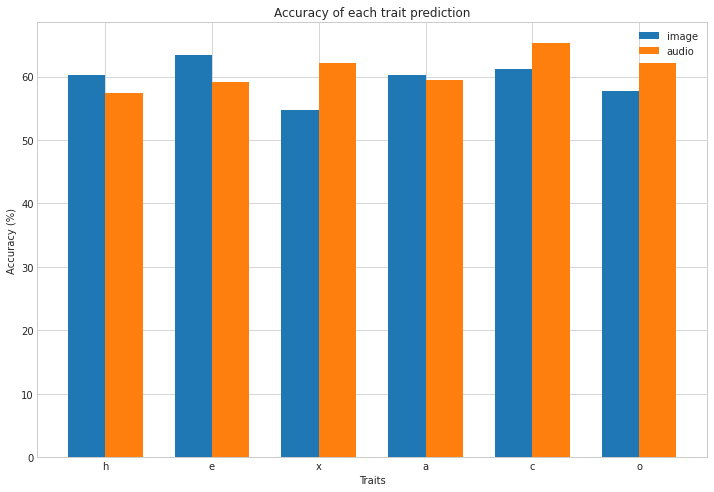

In [18]:
width =.35

fig, ax = plt.subplots(figsize=(12,8))

ax.bar(np.arange(6)      ,result_image[:,0] * 100, width=width, label='image', ecolor='black', capsize=10)
ax.bar(np.arange(6)+width,result_audio[:,0] * 100, width=width, label='audio', ecolor='black', capsize=10)

ax.set_xlabel('Traits')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Accuracy of each trait prediction')
ax.set_xticks(np.arange(6) + width / 2)
ax.set_xticklabels(traits)
ax.legend()

plt.show()

In [19]:
print(f"On average, image accuracy is {round(result_image[:,0].mean(),2)} and audio accuracy is {round(result_audio[:,0].mean(),2)}")
print(f"On average, image    score is {round(result_image[:,1].mean(),2)} and audio    score is {round(result_audio[:,1].mean(),2)}")
print(f"On average, image      std is {round(result_image[:,2].mean(),2)} and audio      std is {round(result_audio[:,2].mean(),2)}")

On average, image accuracy is 0.6 and audio accuracy is 0.61
On average, image    score is 0.48 and audio    score is 0.56
On average, image      std is 0.09 and audio      std is 0.06
